## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
%matplotlib inline
from skimage.feature import hog
from lesson_functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from scipy.ndimage.measurements import label

## 1. Train a linear SVM classifier
### 1.1 Histogram of Oriented Gradient (HOG)

In [2]:
def show_hog(img, image_path = './output_images/test01.png', save_img = False):
    feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    fig, ax = plt.subplots(3, 3, figsize=(30,30))
    #fig.tight_layout()
    for i in range(3):
        ax[i][0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB));
        ax[i][0].set_title('Original Image', fontsize=20);
        ax[i][1].imshow(feature_image[:,:,i], cmap = 'gray');
        ax[i][1].set_title(str(i)+'-channel Image', fontsize=20);
        features, hog_img = get_hog_features(feature_image[:,:,i], orient, 
            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        ax[i][2].imshow(hog_img, cmap = 'gray');
        ax[i][2].set_title(str(i)+'-channel HOG Image', fontsize=20);
        for j in range(3):
            ax[i][j].set_xticks(())
            ax[i][j].set_yticks(())
    if save_img:
        plt.savefig(image_path)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


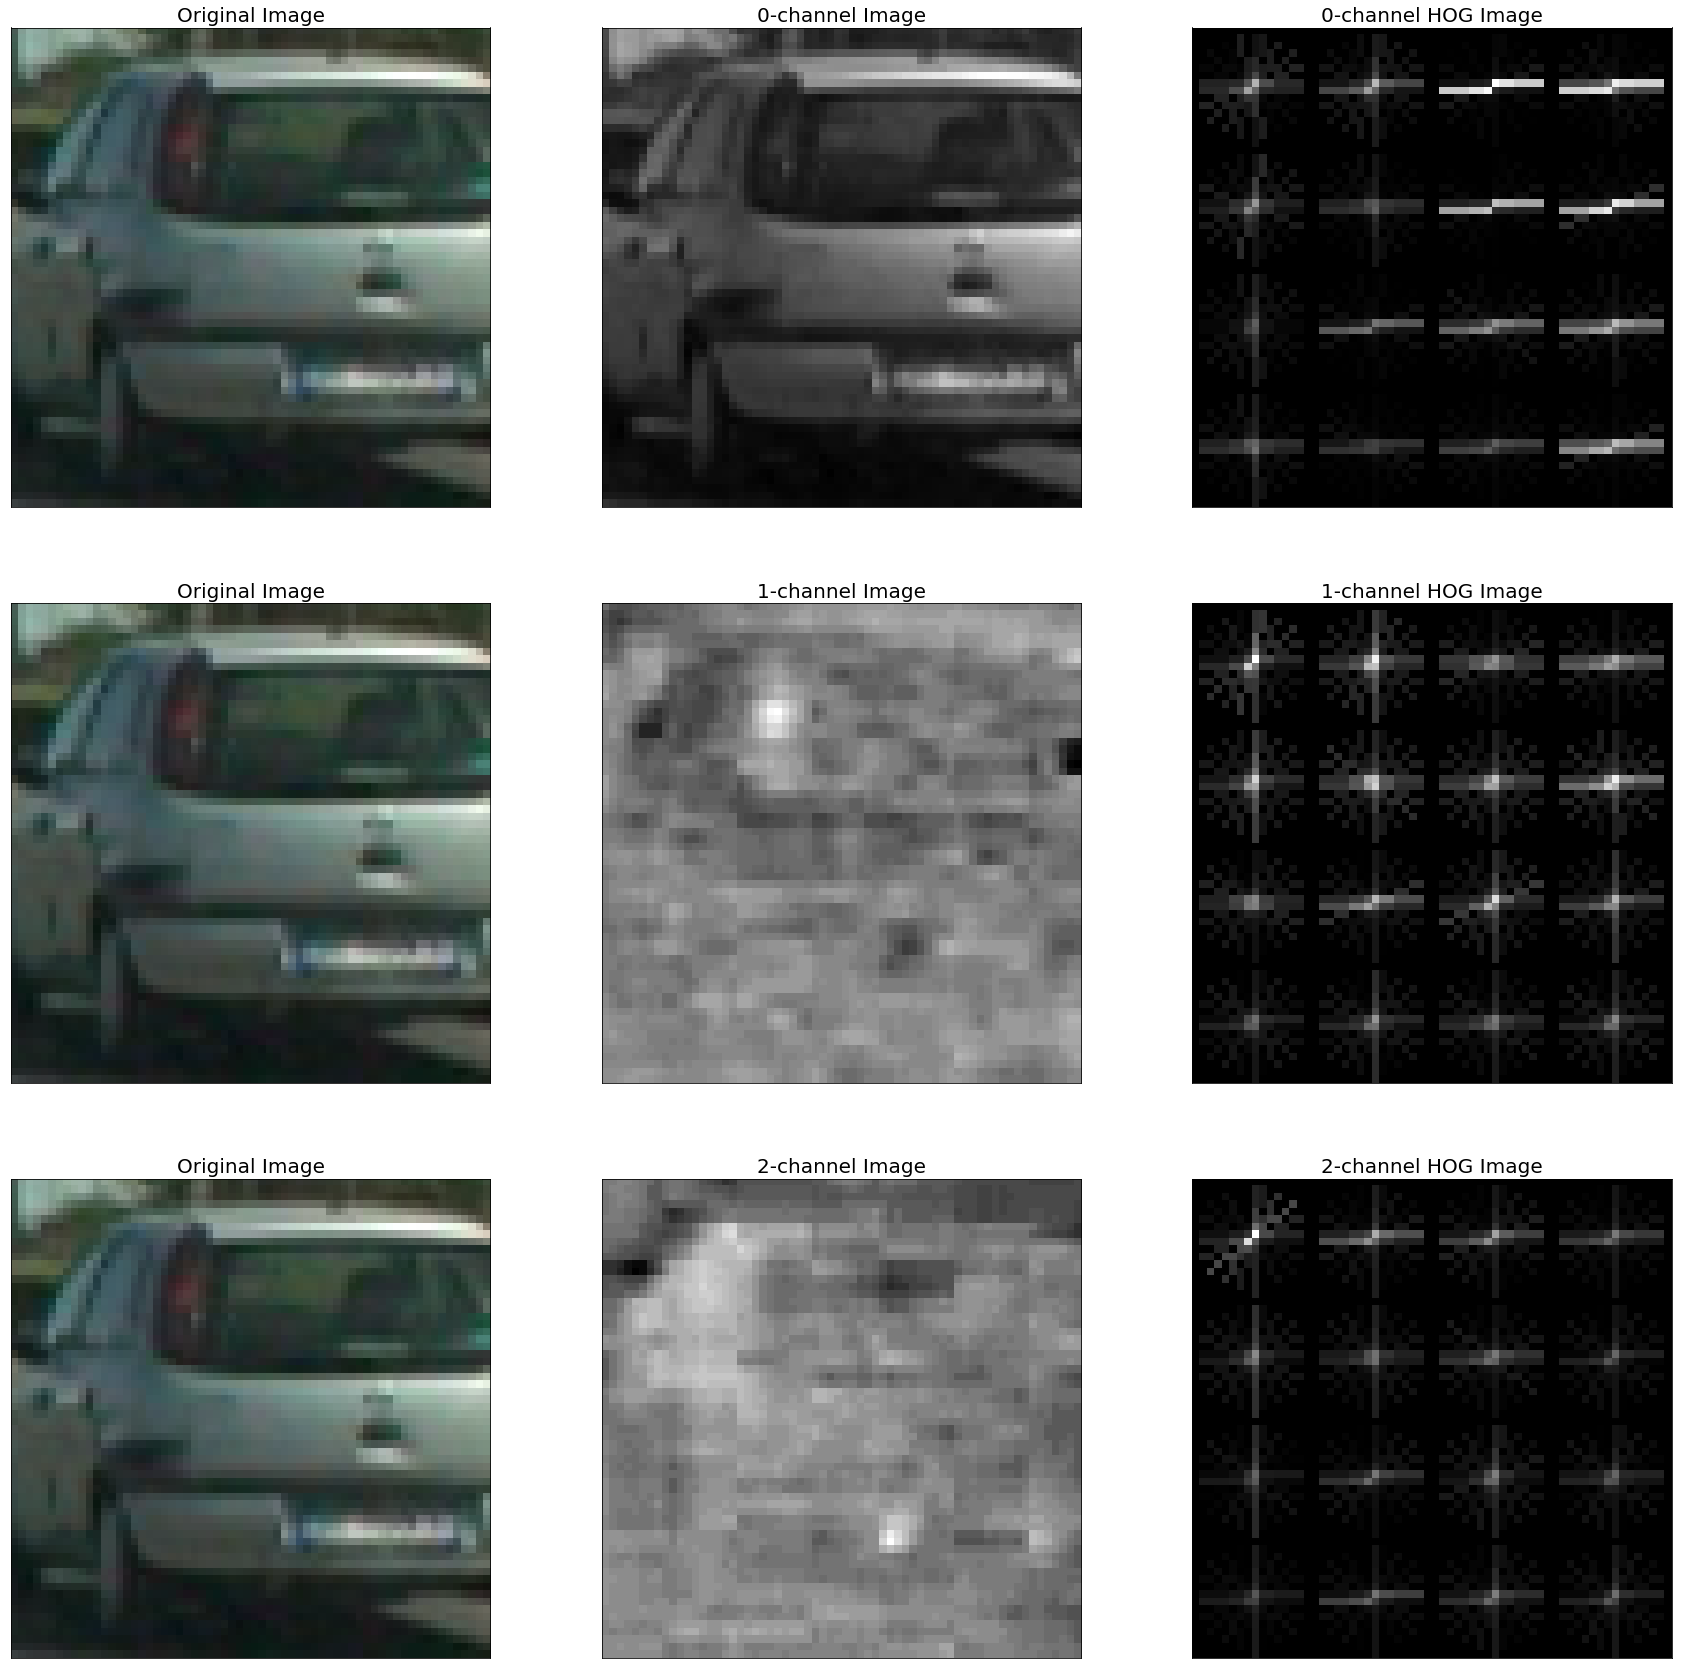

In [3]:
#show HOG image for a test image with vehicle
car_img = cv2.imread('./vehicles/GTI_Right/image0333.png')
image_path = './output_images/hog_GTI_Right_image0333.png'
show_hog(car_img, image_path = image_path, save_img = False)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


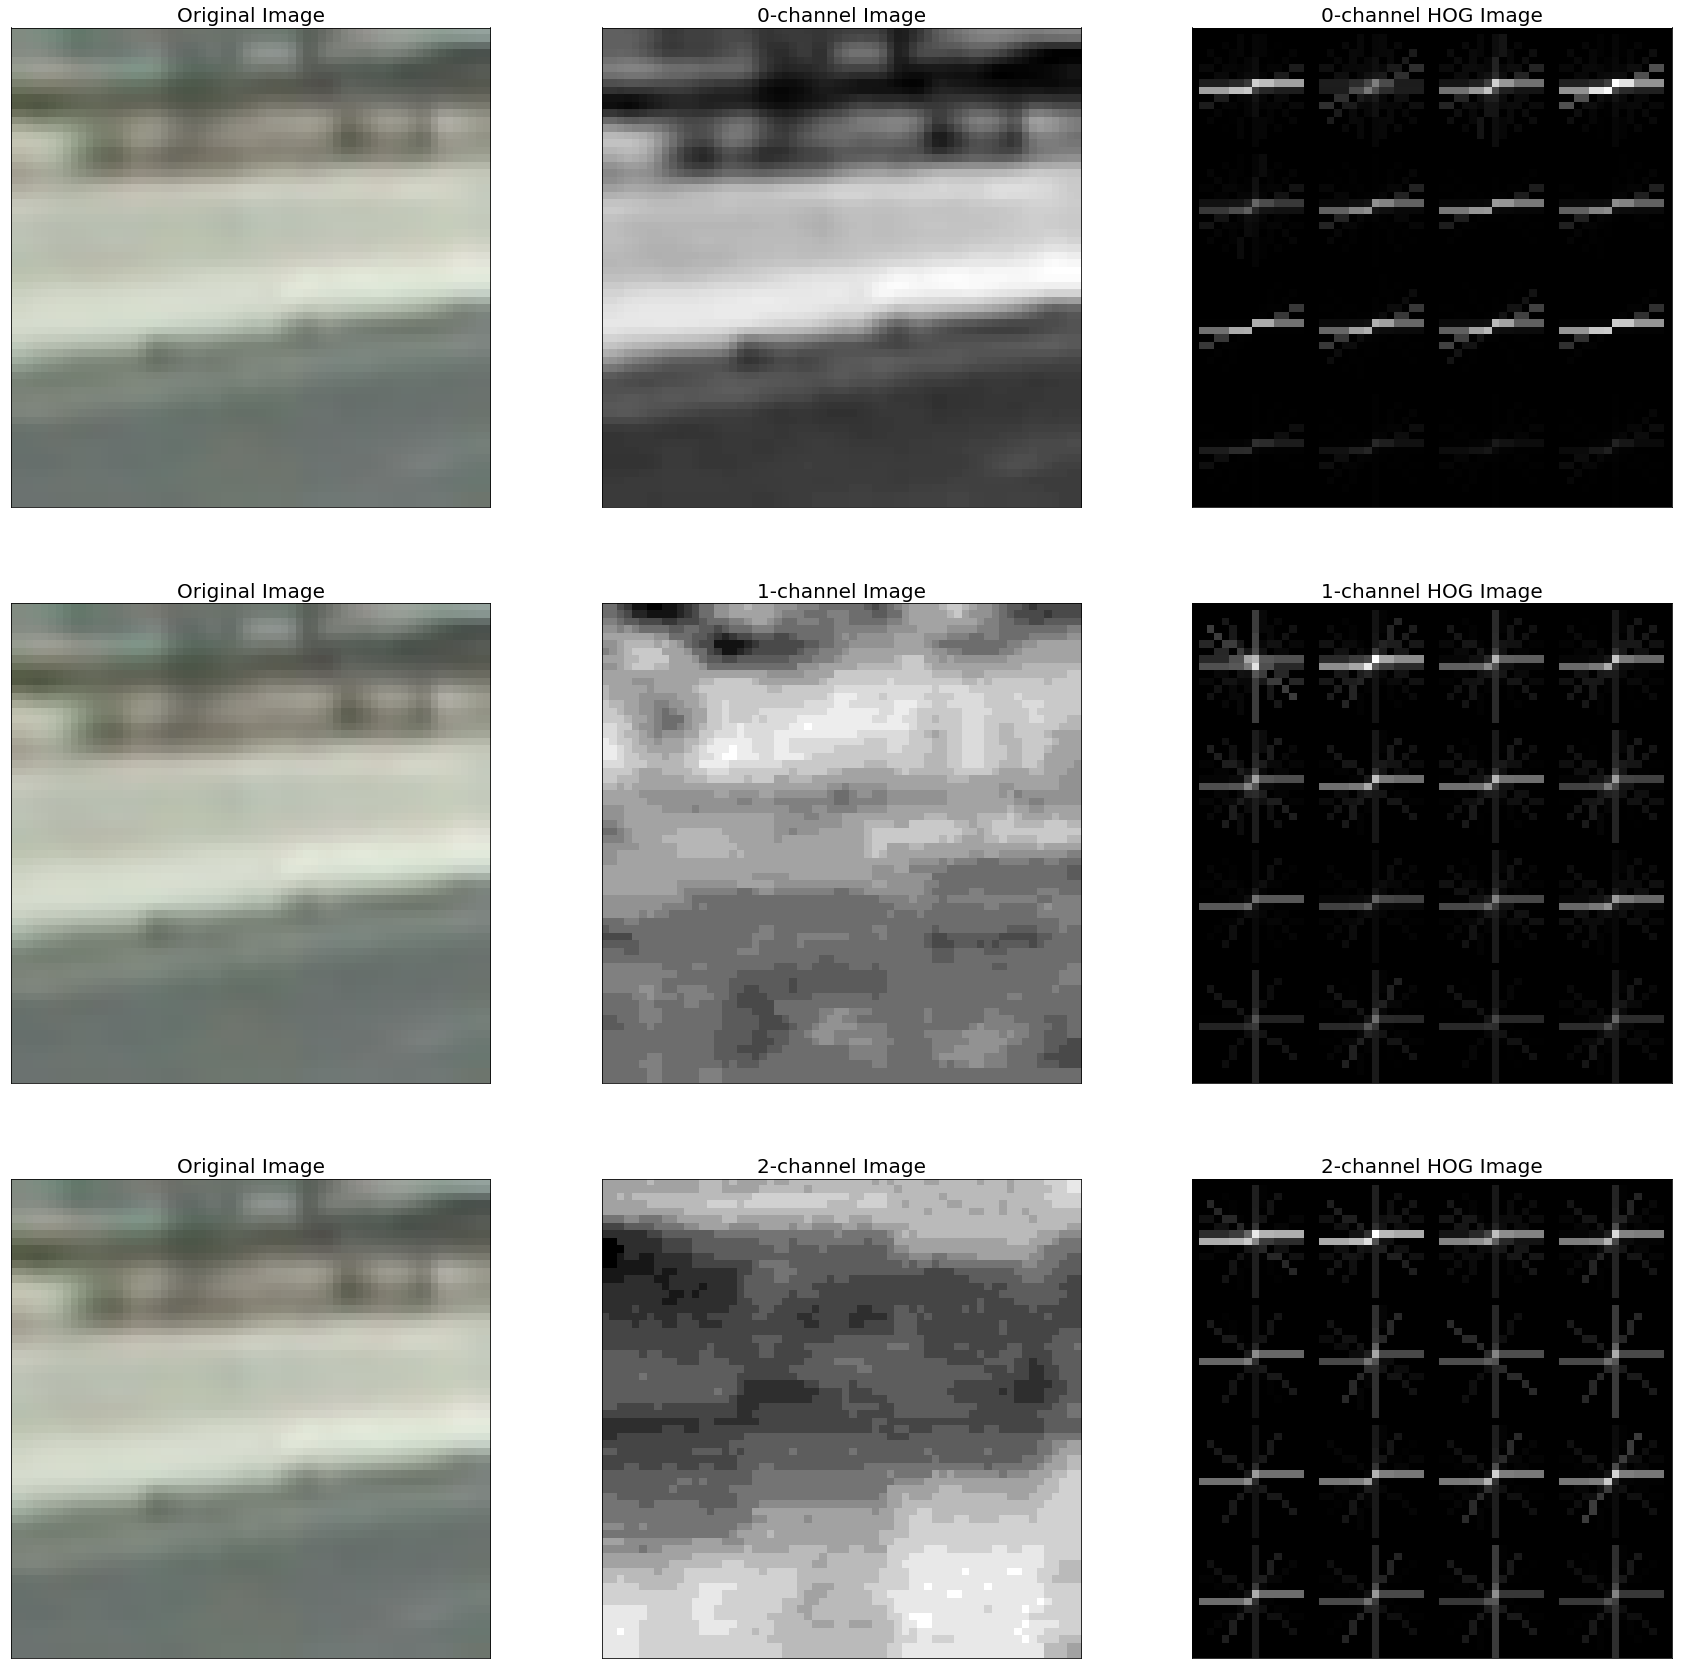

In [4]:
#show HOG image for a test image without vehicle
noncar_img = cv2.imread('./non-vehicles/GTI/image1007.png')
image_path = './output_images/hog_GTI_image1007.png'
show_hog(noncar_img, image_path = image_path, save_img = False)

### 1.2 Color Histograms

In [5]:
def show_colorhist(img, image_path = './output_images/test01.png', save_img = False):
    feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    hist_bins = 32
    hist0, hist1, hist2, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, vis = True)
    #print(bincen)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, hist0[0])
    plt.xlim(0, 256)
    plt.title('0-channel Histogram')
    plt.subplot(132)
    plt.bar(bincen, hist1[0])
    plt.xlim(0, 256)
    plt.title('1-channel Histogram')
    plt.subplot(133)
    plt.bar(bincen, hist2[0])
    plt.xlim(0, 256)
    plt.title('2-channel Histogram')
    fig.tight_layout()
    if save_img:
        plt.savefig(image_path)

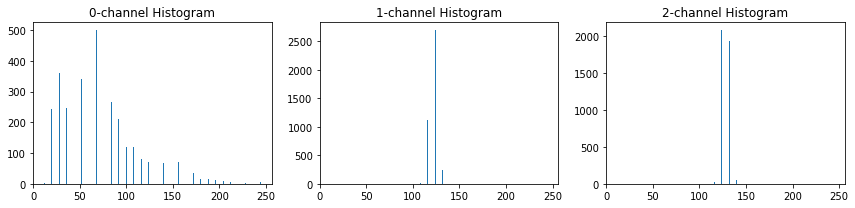

In [6]:
#show color histogram for a test image with vehicle
image_path = './output_images/colorhist_GTI_Right_image0333.png'
show_colorhist(car_img, image_path = image_path, save_img = False)

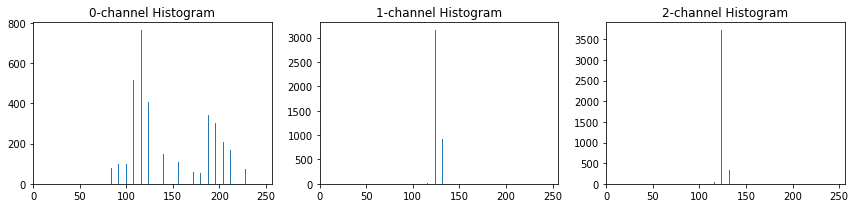

In [7]:
#show color histogram for a test image without vehicle
image_path = './output_images/colorhist_GTI_image1007.png'
show_colorhist(noncar_img, image_path = image_path, save_img = False)

### 1.3 Feature Normalization

In [8]:
# Make lists of vehicle/non-vehicle images
vehicles = glob.glob('./vehicles/*/*')
nonvehicles = glob.glob('./non-vehicles/*/*')

In [9]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
hist_bins = 32
spatial_size = (32, 32)
color_space = 'YCrCb'
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

In [10]:
%%time
vehicles_feat = extract_features(vehicles, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)
nonvehicles_feat = extract_features(nonvehicles, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


CPU times: user 1min 45s, sys: 3.93 s, total: 1min 49s
Wall time: 2min 28s


In [11]:
# Create an array stack of feature vectors
# The right format to sklearn StandardScaler: a numpy array where each row is a single feature vector
X = np.vstack((vehicles_feat, nonvehicles_feat)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [12]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(scaled_X[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356


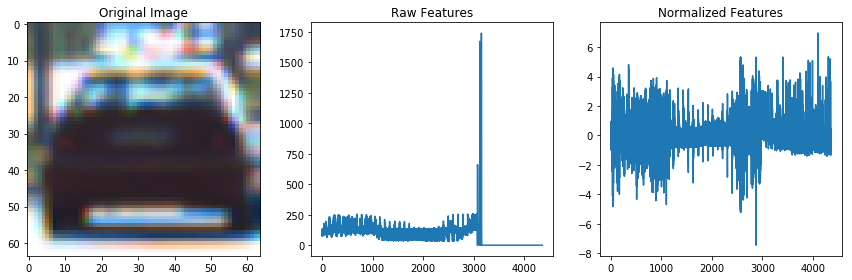

In [13]:
# randomly choose an image with vehicle
car_ind = np.random.randint(0, len(vehicles_feat))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(cv2.imread(vehicles[car_ind]), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
#plt.savefig('./output_images/normalize_feats.png')

### 1.4 Preparation

In [14]:
# Define the labels vector
y = np.hstack((np.ones(len(vehicles_feat)), np.zeros(len(nonvehicles_feat))))

In [15]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### 1.5 Tune SVM parameters

In [16]:
%%time
parameters = {'C':[1e-4, 3e-4, 1e-3, 3e-3, 1e-2]}
             #', loss': ['hinge','squared_hinge']} 
             #', penalty':['l1','l2'], 
svc = LinearSVC()
models = GridSearchCV(estimator = svc, 
                      param_grid = parameters,
                      scoring = ['accuracy', 'f1'],
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1,
                      refit = 'f1')

models.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min finished


CPU times: user 30.6 s, sys: 2.71 s, total: 33.3 s
Wall time: 1min 53s


In [17]:
# best f1 score
print('Best f1 score = {:.4f}'.format(models.best_score_))
# best parameter C
print('Best parameters:',models.best_params_)

Best f1 score = 0.9933
Best parameters: {'C': 0.0003}


### 1.6 Train the model

In [18]:
svc_final = LinearSVC(C = models.best_params_['C'])
svc_final.fit(X_train, y_train)
y_pred = svc_final.predict(X_test)

In [19]:
print('Test set accuracy = {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Test set F1 score = {:.4f}'.format(f1_score(y_test, y_pred)))

Test set accuracy = 0.9958
Test set F1 score = 0.9957


In [20]:
# Dump the svc_final classifier with Pickle
svc_pkl_filename = 'svc_final.pkl'
# Open the file to save as pkl file
svc_pkl = open(svc_pkl_filename, 'wb')
pickle.dump(svc_final, svc_pkl)
# Close the pickle instances
svc_pkl.close()

## 2. Sliding Window Search

In [119]:
# Read a test image
img = cv2.imread('./test_images/images000.jpeg')
# Specify Min and max in y to search in slide_window()
y_start_stop = [380, 700]
# Generate a list of window with size 128x128 and search for cars
windows_128 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))
hot_windows_128 = search_windows(img, windows_128, svc_final, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
# Generate a list of window with size 96x96 and search for cars
windows_96 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
hot_windows_96 = search_windows(img, windows_96, svc_final, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
# Generate a list of window with size 64x64 and search for cars
windows_64 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
hot_windows_64 = search_windows(img, windows_64, svc_final, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
windows = windows_128 + windows_96 #+ windows_64
hot_windows = search_windows(img, windows, svc_final, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)                       


# Draw boxes around windows with cars found
window_img = draw_boxes(img, hot_windows_128, color=(0, 0, 255), thick=6)
window_img_2 = draw_boxes(img, hot_windows_96, color=(0, 0, 255), thick=6)
window_img_3 = draw_boxes(img, hot_windows_64, color=(0, 0, 255), thick=6)                    
out_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6) 

[]

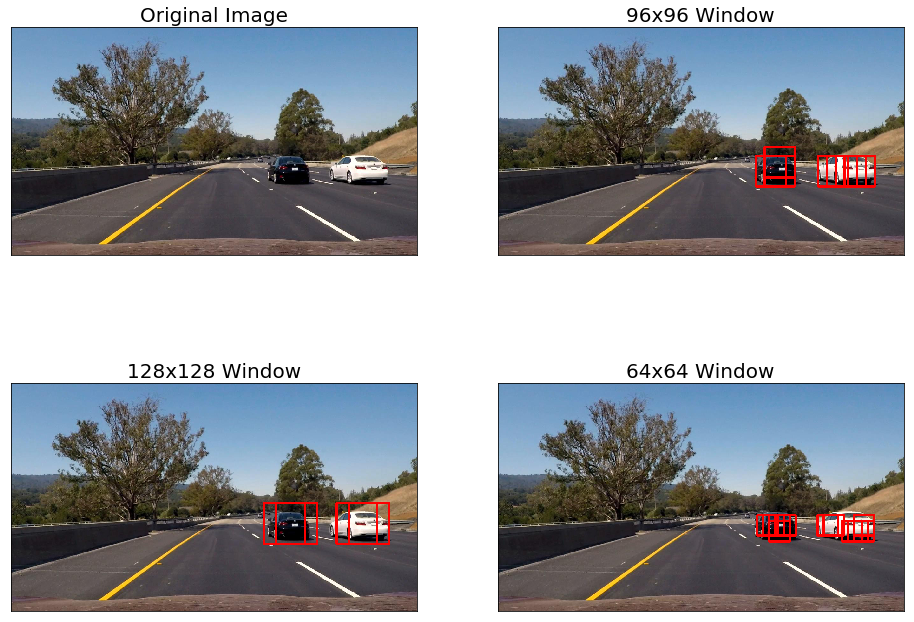

In [122]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
ax[0][0].set_title('Original Image', fontsize=20);
#ax[0][0].imshow(cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))
#ax[0][0].set_title('Marked Image', fontsize=20);
ax[0][0].set_xticks(())
ax[0][0].set_yticks(())
ax[1][0].imshow(cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR))
ax[1][0].set_title('128x128 Window', fontsize=20);
ax[1][0].set_xticks(())
ax[1][0].set_yticks(())
ax[0][1].imshow(cv2.cvtColor(window_img_2, cv2.COLOR_RGB2BGR))
ax[0][1].set_title('96x96 Window', fontsize=20);
ax[0][1].set_xticks(())
ax[0][1].set_yticks(())
ax[1][1].imshow(cv2.cvtColor(window_img_3, cv2.COLOR_RGB2BGR))
ax[1][1].set_title('64x64 Window', fontsize=20);
ax[1][1].set_xticks(())
ax[1][1].set_yticks(())
#image_path = './output_images/sliding_window_search.jpg'
#plt.savefig(image_path)

## 3. Video Implementation
### 3.1 Heatmap Thresholding

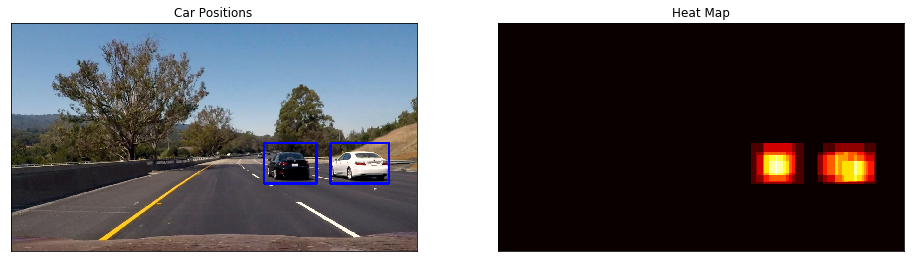

In [127]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)

heat = add_heat(heat, hot_windows_128)
heat = add_heat(heat, hot_windows_96)
heat = add_heat(heat, hot_windows_64)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, .8)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig, ax = plt.subplots(1, 2, figsize = (16, 12))
ax[0].imshow(draw_img)
ax[0].set_title('Car Positions')
ax[0].set_xticks(())
ax[0].set_yticks(())

ax[1].imshow(heatmap, cmap='hot')
ax[1].set_title('Heat Map')
ax[1].set_xticks(())
ax[1].set_yticks(())
#image_path = './output_images/filter.jpg'
#plt.savefig(image_path)

### 3.2 Pipeline

In [113]:
import collections

class VehicleDetector():
    def __init__(self):
        # values of quadratic fit of the previous 5 frames
        self.hot_windows = collections.deque(maxlen = 5)
        
        # keep account of frame number
        self.frameNum = 0
        
    def pipeline(self, frame):
        img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        #print(img.shape)
        hot_windows = search_windows(img, windows, svc_final, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        self.hot_windows.append(hot_windows)

        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        for hot_w in self.hot_windows:
            heat = add_heat(heat, hot_w)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 2.)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)
        self.frameNum += 1
        #return cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
        return draw_img

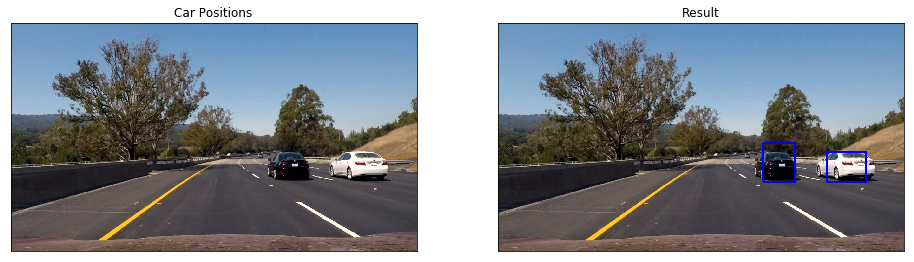

In [124]:
img = mpimg.imread('./test_images/images000.jpeg')
vehicle_detector = VehicleDetector()

result = vehicle_detector.pipeline(img)

fig, ax = plt.subplots(1, 2, figsize = (16, 12))
ax[0].imshow(img)
ax[0].set_title('Car Positions')
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[1].imshow(result)
ax[1].set_title('Result')
ax[1].set_xticks(())
ax[1].set_yticks(())
#image_path = './output_images/final_pipeline.jpg'
#plt.savefig(image_path)

In [107]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [108]:
# output test images from video
output_dir = "test_imgs_output/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
clip1 = VideoFileClip("test_video.mp4")
clip_out = clip1.to_images_sequence(output_dir + 'images%03d.jpeg') #NOTE: this function expects color images!!
#%time clip_out.write_videofile(output_dir + 'project_video_with_lane3.mp4', audio=False)

[MoviePy] Writing frames test_imgs_output/images%03d.jpeg.


  0%|          | 0/1 [00:00<?, ?it/s]
2it [00:00, 14.06it/s]               
4it [00:00, 14.03it/s]
6it [00:00, 13.79it/s]
8it [00:00, 13.57it/s]
10it [00:00, 13.57it/s]
12it [00:00, 13.74it/s]
14it [00:01, 13.58it/s]
16it [00:01, 13.52it/s]
18it [00:01, 13.53it/s]
20it [00:01, 13.39it/s]
22it [00:01, 13.25it/s]
24it [00:01, 13.57it/s]
26it [00:01, 13.79it/s]
28it [00:02, 13.89it/s]
30it [00:02, 14.00it/s]
32it [00:02, 14.14it/s]
34it [00:02, 14.04it/s]
36it [00:02, 14.21it/s]
38it [00:02, 14.17it/s]

[MoviePy]: Done writing frames test_imgs_output/images%03d.jpeg.



In [115]:
# output_dir = "test_videos_output/"
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
    
vehicle_detector = VehicleDetector()

clip1 = VideoFileClip("project_video.mp4")
clip_out = clip1.fl_image(vehicle_detector.pipeline) 
%time clip_out.write_videofile('project_video_with_box.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_with_lane0.mp4
[MoviePy] Writing video test_videos_output/project_video_with_lane0.mp4



 24%|██▍       | 303/1261 [12:56<45:10,  2.83s/it]


 48%|████▊     | 605/1261 [26:09<27:33,  2.52s/it]


 72%|███████▏  | 907/1261 [39:15<18:36,  3.15s/it]


 96%|█████████▌| 1205/1261 [52:11<02:24,  2.59s/it]


100%|█████████▉| 1260/1261 [54:33<00:02,  2.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_with_lane0.mp4 

CPU times: user 53min 46s, sys: 27.7 s, total: 54min 14s
Wall time: 54min 34s
